In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_train = pd.read_csv('D:\\RnD\\Nets\\RNN\\data\\Google_Stock_Price_Train.csv')
train = data_train[['Open']].values

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

x_train = []
y_train = []
timesteps = 5
for i in range(timesteps, len(train_scaled)):
    x_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)


In [3]:
input_size = 1
hidden_size = 100
output_size = 1
learning_rate = 0.001
epochs = 100

Wxh = np.random.randn(hidden_size, input_size) * 0.01
Whh = np.random.randn(hidden_size, hidden_size) * 0.01
Why = np.random.randn(output_size, hidden_size) * 0.01

bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [5]:
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(x_train)):
        hs = np.zeros((timesteps + 1, hidden_size, 1))
        xs = {}
        for t in range(timesteps):
            xs[t] = x_train[i][t]
            xs[t] = xs[t].reshape(-1, 1)
            hs[t+1] = relu(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t]) + bh)

        y_pred = np.dot(Why, hs[timesteps]) + by
        loss = mean_squared_error(y_train[i], y_pred)
        total_loss += loss

        dy = y_pred - y_train[i]
        dWhy = np.dot(dy, hs[timesteps].T)
        dby = dy

        dh = np.dot(Why.T, dy)
        for t in reversed(range(timesteps)):
            dh_raw = dh * relu_derivative(hs[t+1])
            dbh = dh_raw
            dWxh = np.dot(dh_raw, xs[t].T)
            dWhh = np.dot(dh_raw, hs[t].T)
            dh = np.dot(Whh.T, dh_raw)

            Wxh -= learning_rate * dWxh
            Whh -= learning_rate * dWhh
            bh -= learning_rate * dbh

        Why -= learning_rate * dWhy
        by -= learning_rate * dby

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(x_train)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')



Epoch [10/100], Loss: 0.073866
Epoch [20/100], Loss: 0.053408
Epoch [30/100], Loss: 0.008640
Epoch [40/100], Loss: 0.000583
Epoch [50/100], Loss: 0.000345
Epoch [60/100], Loss: 0.000310
Epoch [70/100], Loss: 0.000297
Epoch [80/100], Loss: 0.000290
Epoch [90/100], Loss: 0.000286
Epoch [100/100], Loss: 0.000283


In [6]:
data_test = pd.read_csv('D:\\RnD\\Nets\\RNN\\data\\Google_Stock_Price_Test.csv')
real_stock_price = data_test[['Open']].values

data_total = pd.concat((data_train['Open'], data_test['Open']), axis=0)
inputs = data_total[len(data_total) - len(data_test) - timesteps:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(timesteps, len(inputs)):
    x_test.append(inputs[i - timesteps:i, 0])
x_test = np.array(x_test)


In [7]:
predicted_stock_price = []
for i in range(len(x_test)):
    hs = np.zeros((timesteps + 1, hidden_size, 1))
    xs = {}
    for t in range(timesteps):
        xs[t] = x_test[i][t]
        xs[t] = xs[t].reshape(-1, 1)
        hs[t+1] = relu(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t]) + bh)
    y_pred = np.dot(Why, hs[timesteps]) + by
    predicted_stock_price.append(y_pred[0][0])
predicted_stock_price = np.array(predicted_stock_price)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))

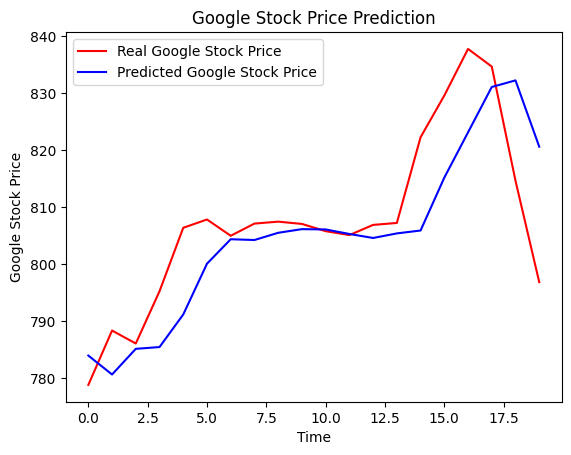

In [8]:
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
